### Using keras to load images and design a CNN. This will be trained using the google colab

In [21]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
import matplotlib.pyplot as plt
import glob
import numpy as np

In [24]:
#For augmentation

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=(0.1,1.5))

### Looking at the augmentation techniques

In [30]:
img_path = '/Users/rmartinshort/Documents/DS_projects/fruit_classification/tropical-fruits-DB-1024x768/orange/orange_001.jpg'

nimages = 30
img = load_img(img_path)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, xpix, ypix)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, xpix, ypix)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='orange_example', save_format='jpeg'):
    i += 1
    if i >= nimages:
        break  # otherwise the generator would loop indefinitely

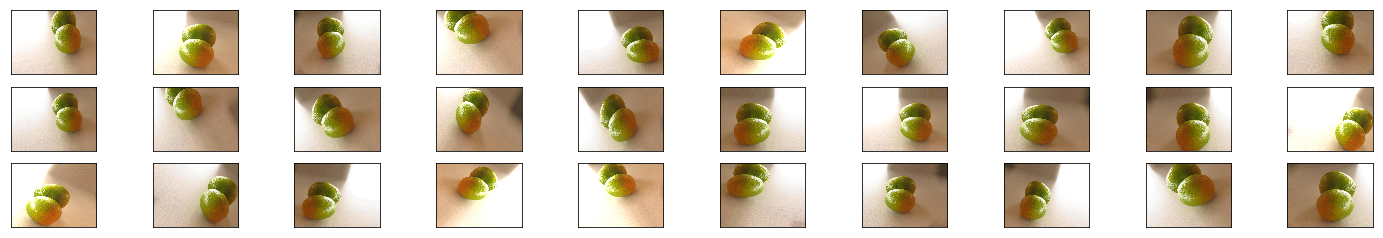

In [31]:
fig = plt.figure(figsize=(25, 4))
images = glob.glob('preview/*')

for idx in np.arange(nimages):
  ax = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[])
  ax.imshow(Image.open(images[idx]))

In [54]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [56]:
train_dir = 'tropical-fruits-DB-1024x768/'
BATCH_SIZE = 10
HEIGHT = 300
WIDTH = 300

In [57]:
base_model = VGG16(weights='imagenet',include_top=False,input_shape=(HEIGHT,WIDTH,3))

58892288/58889256 [==============================] - 3s 0us/step


In [40]:
datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rescale = 1.0/255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=(0.1,1.5))

In [58]:
train_generator = datagen.flow_from_directory(train_dir,target_size=(HEIGHT,WIDTH),batch_size=BATCH_SIZE)

Found 2633 images belonging to 15 classes.


In [62]:
#Here is a summary of the VGG16 model that we've just generated
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

In [63]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    
    #Prevent the CNN layers from being trainable
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [68]:
class_list = sorted(glob.glob('/Users/rmartinshort/Documents/DS_projects/fruit_classification/tropical-fruits-DB-1024x768/*'))

In [69]:
classes = [x.split('/')[-1] for x in class_list]

In [70]:
classes

['agata_potato',
 'asterix_potato',
 'cashew',
 'diamond_peach',
 'fuji_apple',
 'granny_smith_apple',
 'honneydew_melon',
 'kiwi',
 'nectarine',
 'onion',
 'orange',
 'plum',
 'spanish_pear',
 'taiti_lime',
 'watermelon']

In [71]:
#These are the number of nodes in the layers that we're going to add 
FC_LAYERS = [1024, 1024]

#May want to use dropout to reduce overfitting, but we can experiment with this
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [73]:
finetune_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

In [74]:
#print the configuration setup of the model
finetune_model.get_config()

{'name': 'model_1',
 'layers': [{'name': 'input_2',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 300, 300, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_2'},
   'inbound_nodes': []},
  {'name': 'block1_conv1',
   'class_name': 'Conv2D',
   'config': {'name': 'block1_conv1',
    'trainable': False,
    'filters': 64,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'inbound_nodes': [[['input_2', 0, 0, {}]]]},
  {'name

To actually train the model, we'll use Google Colab